# Final Project - Stock Data Analysis

## Milestone 2 - CSV Data 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt 
from bs4 import BeautifulSoup
import requests
from datetime import datetime
import json
import time
import sqlite3 as sql
import mplfinance as mpf
from mpl_finance import candlestick_ohlc

c:\users\bhush\.virtualenvs\dsc540-sg-4vple\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


#### Lets import data from csv and check the first 10 rows of data. 

In [2]:
# Importing data into pandas dataframe
z_stock_csv_df = pd.read_csv("Z_Stock.csv")

# Lets check first 10 rows of data. 
z_stock_csv_df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-03,27.650000,28.820000,25.719999,27.740000,27.740000,144700
1,2015-08-04,27.000000,27.030001,24.610001,25.799999,25.799999,129100
2,2015-08-05,27.110001,27.469999,24.559999,25.240000,25.240000,107700
3,2015-08-06,24.809999,26.950001,22.990000,26.950001,26.950001,73100
4,2015-08-07,27.500000,27.500000,24.200001,26.500000,26.500000,52200
5,2015-08-10,25.760000,26.500000,25.459999,26.139999,26.139999,51400
6,2015-08-11,25.440001,26.020000,24.559999,25.379999,25.379999,141000
7,2015-08-12,25.000000,26.209999,25.000000,25.990000,25.990000,172600
8,2015-08-13,26.000000,26.600000,25.760000,26.200001,26.200001,229600
9,2015-08-14,26.129999,26.209999,24.660000,25.190001,25.190001,103300


#### Lets replace headers to make them more understanble. 

In [3]:
# Define new header list.
headers = ['z_trading_date', 'stock_open_price', 'stock_high_price', 'stock_low_price', 'stock_close_price', 'stock_adjusted_close_price', 'stock_day_volume']

# Assign new header names to dataframe
z_stock_csv_df.columns = headers

# Lets check if those are applied correctly. 
z_stock_csv_df.columns

Index(['z_trading_date', 'stock_open_price', 'stock_high_price',
       'stock_low_price', 'stock_close_price', 'stock_adjusted_close_price',
       'stock_day_volume'],
      dtype='object')

So I have csv data imported and we applied new headers to make them more understandable. 

Checking the duplicate existance. 

In [4]:
duplicateRowsDF = z_stock_csv_df[z_stock_csv_df.duplicated(['z_trading_date'])]
duplicateRowsDF.head()

,z_trading_date,stock_open_price,stock_high_price,stock_low_price,stock_close_price,stock_adjusted_close_price,stock_day_volume


Good to see there are no dupluicate values. 

```null``` values are not at all good for the model. I am going to check if there are any ```null``` in any of the column. 

In [5]:
z_stock_csv_df.isnull().sum()

z_trading_date                0
stock_open_price              0
stock_high_price              0
stock_low_price               0
stock_close_price             0
stock_adjusted_close_price    0
stock_day_volume              0
dtype: int64

It is easier to find outliers using histogram. Lets see histogram for all the data columns. 

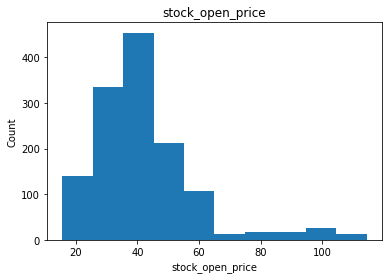

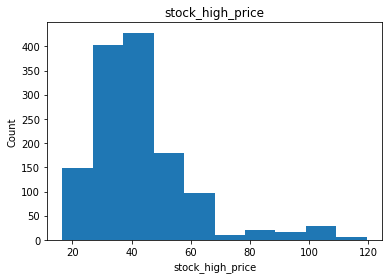

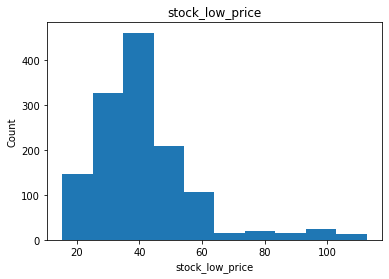

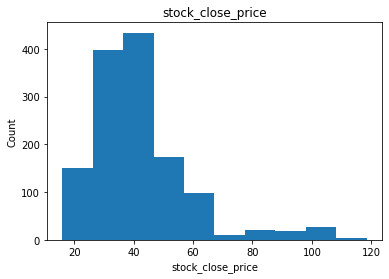

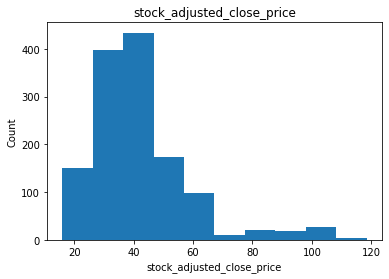

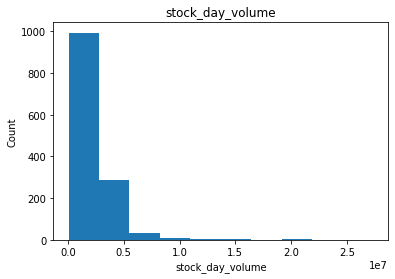

In [6]:
titles = ['stock_open_price', 'stock_high_price', 'stock_low_price', 'stock_close_price', 'stock_adjusted_close_price', 'stock_day_volume']

# Get each column with its index.
for i, col in enumerate(z_stock_csv_df.columns[1:]):
    # use name of column to pass data for hist function.
    plt.hist(z_stock_csv_df[col])
    
    # use index to get title. 
    plt.title(titles[i])
    
    # use name of column as x-axis label
    plt.xlabel(col)
    
    # Since its histogram use static label count.
    plt.ylabel('Count')
    
    # Display plot.
    plt.show()


Looks like traded valume need to be standardized to millions for better visibility. 

<AxesSubplot:>

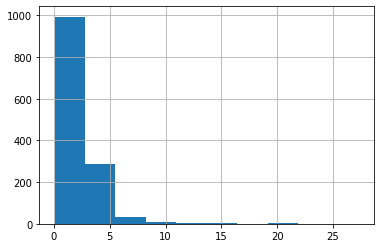

In [7]:
temp_volume_df = z_stock_csv_df['stock_day_volume'] / 1000000
temp_volume_df.hist()

Open, High, low, Close, Adjust close and volume are showing higher decimal places. However stock data generally been handled with 2 decimal places. Hence converting all the data columns to 2 decimal. 

In [8]:
z_stock_csv_df['stock_open_price'] = round(z_stock_csv_df[['stock_open_price']], 2)
z_stock_csv_df['stock_high_price'] = round(z_stock_csv_df[['stock_high_price']], 2)
z_stock_csv_df['stock_low_price'] = round(z_stock_csv_df[['stock_low_price']], 2)
z_stock_csv_df['stock_close_price'] = round(z_stock_csv_df[['stock_close_price']], 2)
z_stock_csv_df['stock_adjusted_close_price'] = round(z_stock_csv_df[['stock_adjusted_close_price']], 2)

# stock_day_volume is converted to millions and hence the decimal. 
z_stock_csv_df['stock_day_volume'] = round(z_stock_csv_df[['stock_day_volume']], 2)

z_stock_csv_df.head()

,z_trading_date,stock_open_price,stock_high_price,stock_low_price,stock_close_price,stock_adjusted_close_price,stock_day_volume
0,2015-08-03,27.65,28.82,25.72,27.74,27.74,144700
1,2015-08-04,27.00,27.03,24.61,25.80,25.80,129100
2,2015-08-05,27.11,27.47,24.56,25.24,25.24,107700
3,2015-08-06,24.81,26.95,22.99,26.95,26.95,73100
4,2015-08-07,27.50,27.50,24.20,26.50,26.50,52200


Now since we have data in required format and verified for cleanlines, lets create some technical indicators based on sock_close_price for further analysis. 

In [9]:
z_stock_csv_df['stock_sma10'] = round(z_stock_csv_df['stock_close_price'].rolling(window=10).mean(), 2)
z_stock_csv_df['stock_sma20'] = round(z_stock_csv_df['stock_close_price'].rolling(window=20).mean(), 2)
z_stock_csv_df['stock_sma50'] = round(z_stock_csv_df['stock_close_price'].rolling(window=50).mean(), 2)
z_stock_csv_df['stock_sma100'] = round(z_stock_csv_df['stock_close_price'].rolling(window=100).mean(), 2)
z_stock_csv_df['stock_sma200'] = round(z_stock_csv_df['stock_close_price'].rolling(window=200).mean(), 2)

z_stock_csv_df.tail()

,z_trading_date,stock_open_price,stock_high_price,stock_low_price,stock_close_price,stock_adjusted_close_price,stock_day_volume,stock_sma10,stock_sma20,stock_sma50,stock_sma100,stock_sma200
1331,2020-11-12,108.86,110.72,106.68,107.42,107.42,2910900,101.16,98.17,97.53,84.03,65.85
1332,2020-11-13,108.28,109.12,104.50,106.03,106.03,1604900,102.91,98.62,97.94,84.50,66.15
1333,2020-11-16,104.71,107.97,103.40,107.04,107.04,3118300,104.69,99.05,98.41,84.98,66.45
1334,2020-11-17,106.76,107.88,103.90,105.26,105.26,2247400,106.05,99.39,98.90,85.47,66.73
1335,2020-11-18,104.32,106.22,100.54,102.24,102.24,2345600,106.28,99.57,99.30,85.93,67.00


## Milestone 3 - Web Scrapping

In my initial data source hunting task I came across ```tradingview.com``` this is great site to get stock's technical indicator data. However, when time came (this week) to really use it, I noticed that the data is coming in java script tags and not HTML tag as required by ```BeautifulSoup```. 
All the efforts gone wasted and had to restart web data hunting, but luckily it did not take a whole lot to encounter with ```finscreener.com```.  
Anyway too much of a talk about data hunting lets do some scrapping!!! 

In [10]:
# Lets import html data from web-browser
page =  requests.get('https://www.finscreener.com/tittech/technical-analysis?&cp=7627&tframe=4')

# soup the data with BeautifulSoup. 
soup = BeautifulSoup(page.content, 'html.parser')

#### Lets get classic support and resistence levels of the stock.

In [11]:
# Get to the class containing support/resistence levels for the stock. 
oscillators = soup.find_all(class_ ='col-lg-6')[1]

# Locate exact row containing data.
pp = oscillators.find_all(class_ ='fs_tech_ta_pp_wrapper')

# Get all tr tags for the data. 
classic = pp[0].find_all('tr')[1]

# Create list with the actual data from data tag 'td'
data_rows1 = [td.get_text().strip() for td in classic.findAll('td')]

# Remove first index as its just a name and not important for our analysis. 
data_rows1.pop(0)

# Header for the pivot levels
header = ["stock_s1","stock_s2","stock_s3","stock_pp","stock_r1","stock_r2", "stock_r3"]

# Create data frame from the web data collected. 
web_data_df = pd.DataFrame(data_rows1)

# Transpose to bring dataframe in required structure
web_data_df = web_data_df.transpose()

# Attach columns to dataframe. 
web_data_df.columns = header

# Display final data. 
print(web_data_df)

  stock_s1 stock_s2 stock_s3  stock_pp  stock_r1  stock_r2  stock_r3
0  94.0833  97.3067  99.7733  102.9967  105.4633  108.6867  111.1533


#### Lets get RSI indicator for the stock.

With previous experince of collecting pivot levels, I am combining some of the steps to collect data. 

In [12]:
# Get to the class containing RSI for the stock and retrieve row containing data. 
technical_indicators = oscillators.find_all(class_ ='fs_tech_ta_ti')[0].find_all('tr')[4]

# Create data array by reading 'td' tags.
data_rows1 = np.array([td.get_text().strip() for td in technical_indicators.findAll('td')])

# Reshape row data to 2 x 3 table format.
data_rows1 = data_rows1.reshape(2,3)

# Select required part of the data only.
data_rows1 = data_rows1[:,1:-1] 

# assign data to correct variable. 
rsi = data_rows1[1]

# print data collected.
rsi

array(['58.0212'], dtype='<U7')

In [13]:
# Move data to dataframe 
rsi_df = pd.DataFrame([rsi])

# Assign appropriate column name
rsi_df.columns = ["stock_rsi"]

# Display dataframe
rsi_df

,stock_rsi
0,58.0212


#### Lets get MACD 

In [14]:
# Get to the class containing MACD for the stock and retrieve row containing data. 
technical_indicators = oscillators.find_all(class_ ='fs_tech_ta_ti')[0].find_all('tr')[3]

# Create data array by reading 'td' tags.
data_rows1 = np.array([td.get_text().strip() for td in technical_indicators.findAll('td')])

# Reshape row data to 2 x 3 table format.
data_rows1 = data_rows1.reshape(2,3)

# Select required part of the data only.
data_rows1 = data_rows1[:,1:-1] 

# assign data to correct variable.
macd = data_rows1[0]

# print data collected.
print(macd)

['2.1804']


In [15]:
# Move data to dataframe 
macd_df = pd.DataFrame([macd])

# Assign appropriate column name
macd_df.columns = ["stock_macd"]

# Display dataframe
macd_df

,stock_macd
0,2.1804


The steps followed in case of RSI and MACD data are same and I would have used a function to do it. As I wanted to see each step of extraction kept it separate. Might change approach in the final week to make it clean. 

Great!!! So, now we have all the data required from the web source. But when tried to think of joining this data with csv data the main hurdle is this is timeseries data. In case of timeseries you cannnot go only with stock code to join the dataframe but need to consider for which date we collected this data. 

#### Find the date for which the technical indicators are collected. 

In [16]:
# Get to the class containing Date technical data. 
oscillators = soup.find_all(class_ ='col-lg-6')[0]

# Get to exact class containing date. 
pp = oscillators.find_all(class_ ='fs_title_head_panel_most_important')

# Getting to date
classic = pp[0].find_all('td')[-1].get_text()

# Date has other details as well so remove unwanted details. 
date_df = classic.split()
date_df = date_df[:-2]

import re
date_df[1] = ''.join(re.findall(r'\d+', str(date_df[1])[:2]))

# Display collected date.
date_df

['Nov', '19', '2020']

Lets do some date transformations to bring it in required format. 

In [17]:
today_date = '-'.join(date_df)

In [18]:
today = datetime.strptime(today_date, '%b-%d-%Y')
today

datetime.datetime(2020, 11, 19, 0, 0)

In [19]:
date_df = pd.DataFrame([today.strftime("%Y-%m-%d")])
date_df.columns = ["z_trading_date"]
date_df

,z_trading_date
0,2020-11-19


There is better approch to date transformation and will try it in final submission, just avoiding any unknown at this time. 

#### Join the support/resistence levels and other indicators. 

In [20]:
technical_indicators_df =pd.concat([web_data_df, date_df, macd_df, rsi_df], axis=1)
technical_indicators_df

,stock_s1,stock_s2,stock_s3,stock_pp,stock_r1,stock_r2,stock_r3,z_trading_date,stock_macd,stock_rsi
0,94.0833,97.3067,99.7733,102.9967,105.4633,108.6867,111.1533,2020-11-19,2.1804,58.0212


***Checking if join is working fine. This will actually be used at the end once I get data from all the sources. When talking about it I might utilize SQLLite to save all these interim steps and then join all the dataset at the end.***

In [21]:
updated_df = pd.merge(z_stock_csv_df, technical_indicators_df, on='z_trading_date', how='outer')
updated_df

,z_trading_date,stock_open_price,stock_high_price,stock_low_price,stock_close_price,stock_adjusted_close_price,stock_day_volume,stock_sma10,stock_sma20,stock_sma50,...,stock_sma200,stock_s1,stock_s2,stock_s3,stock_pp,stock_r1,stock_r2,stock_r3,stock_macd,stock_rsi
0,2015-08-03,27.65,28.82,25.72,27.74,27.74,144700.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-08-04,27.00,27.03,24.61,25.80,25.80,129100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-08-05,27.11,27.47,24.56,25.24,25.24,107700.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-08-06,24.81,26.95,22.99,26.95,26.95,73100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-08-07,27.50,27.50,24.20,26.50,26.50,52200.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,2020-11-13,108.28,109.12,104.50,106.03,106.03,1604900.0,102.91,98.62,97.94,...,66.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1333,2020-11-16,104.71,107.97,103.40,107.04,107.04,3118300.0,104.69,99.05,98.41,...,66.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1334,2020-11-17,106.76,107.88,103.90,105.26,105.26,2247400.0,106.05,99.39,98.90,...,66.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1335,2020-11-18,104.32,106.22,100.54,102.24,102.24,2345600.0,106.28,99.57,99.30,...,67.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***Since only current day value is available for the technical indicators. Use formulae to calculate the missing values.***

***Note: In the above datasset technical indicators show value only for last row. The rest of the missing values will be filled with calculation as web data can provide technical indicators only for 1 day.***

#### Calculate pivot levels of stock price. 

In [22]:
updated_df['stock_pp'] = np.where(updated_df['stock_pp'].isna(), (updated_df['stock_high_price'] + updated_df['stock_low_price'] + updated_df['stock_close_price'])/3 , updated_df['stock_pp'])
updated_df

,z_trading_date,stock_open_price,stock_high_price,stock_low_price,stock_close_price,stock_adjusted_close_price,stock_day_volume,stock_sma10,stock_sma20,stock_sma50,...,stock_sma200,stock_s1,stock_s2,stock_s3,stock_pp,stock_r1,stock_r2,stock_r3,stock_macd,stock_rsi
0,2015-08-03,27.65,28.82,25.72,27.74,27.74,144700.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,27.4267,NaN,NaN,NaN,NaN,NaN
1,2015-08-04,27.00,27.03,24.61,25.80,25.80,129100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,25.8133,NaN,NaN,NaN,NaN,NaN
2,2015-08-05,27.11,27.47,24.56,25.24,25.24,107700.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,25.7567,NaN,NaN,NaN,NaN,NaN
3,2015-08-06,24.81,26.95,22.99,26.95,26.95,73100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,25.63,NaN,NaN,NaN,NaN,NaN
4,2015-08-07,27.50,27.50,24.20,26.50,26.50,52200.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,26.0667,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,2020-11-13,108.28,109.12,104.50,106.03,106.03,1604900.0,102.91,98.62,97.94,...,66.15,NaN,NaN,NaN,106.55,NaN,NaN,NaN,NaN,NaN
1333,2020-11-16,104.71,107.97,103.40,107.04,107.04,3118300.0,104.69,99.05,98.41,...,66.45,NaN,NaN,NaN,106.137,NaN,NaN,NaN,NaN,NaN
1334,2020-11-17,106.76,107.88,103.90,105.26,105.26,2247400.0,106.05,99.39,98.90,...,66.73,NaN,NaN,NaN,105.68,NaN,NaN,NaN,NaN,NaN
1335,2020-11-18,104.32,106.22,100.54,102.24,102.24,2345600.0,106.28,99.57,99.30,...,67.00,NaN,NaN,NaN,103,NaN,NaN,NaN,NaN,NaN


#### Calculate support levels of stock price. 

In [23]:
updated_df.dtypes

z_trading_date                 object
stock_open_price              float64
stock_high_price              float64
stock_low_price               float64
stock_close_price             float64
stock_adjusted_close_price    float64
stock_day_volume              float64
stock_sma10                   float64
stock_sma20                   float64
stock_sma50                   float64
stock_sma100                  float64
stock_sma200                  float64
stock_s1                       object
stock_s2                       object
stock_s3                       object
stock_pp                       object
stock_r1                       object
stock_r2                       object
stock_r3                       object
stock_macd                     object
stock_rsi                      object
dtype: object

In [24]:
updated_df['stock_pp'] = updated_df['stock_pp'].astype('float64')

In [25]:
# Fill missing resistence levels 'stock_r1'
updated_df['stock_r1'] = np.where(updated_df['stock_r1'].isna(), (updated_df['stock_pp'] * 2) - updated_df['stock_low_price'], updated_df['stock_r1'])
updated_df

,z_trading_date,stock_open_price,stock_high_price,stock_low_price,stock_close_price,stock_adjusted_close_price,stock_day_volume,stock_sma10,stock_sma20,stock_sma50,...,stock_sma200,stock_s1,stock_s2,stock_s3,stock_pp,stock_r1,stock_r2,stock_r3,stock_macd,stock_rsi
0,2015-08-03,27.65,28.82,25.72,27.74,27.74,144700.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,27.426667,29.1333,NaN,NaN,NaN,NaN
1,2015-08-04,27.00,27.03,24.61,25.80,25.80,129100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,25.813333,27.0167,NaN,NaN,NaN,NaN
2,2015-08-05,27.11,27.47,24.56,25.24,25.24,107700.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,25.756667,26.9533,NaN,NaN,NaN,NaN
3,2015-08-06,24.81,26.95,22.99,26.95,26.95,73100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,25.630000,28.27,NaN,NaN,NaN,NaN
4,2015-08-07,27.50,27.50,24.20,26.50,26.50,52200.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,26.066667,27.9333,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,2020-11-13,108.28,109.12,104.50,106.03,106.03,1604900.0,102.91,98.62,97.94,...,66.15,NaN,NaN,NaN,106.550000,108.6,NaN,NaN,NaN,NaN
1333,2020-11-16,104.71,107.97,103.40,107.04,107.04,3118300.0,104.69,99.05,98.41,...,66.45,NaN,NaN,NaN,106.136667,108.873,NaN,NaN,NaN,NaN
1334,2020-11-17,106.76,107.88,103.90,105.26,105.26,2247400.0,106.05,99.39,98.90,...,66.73,NaN,NaN,NaN,105.680000,107.46,NaN,NaN,NaN,NaN
1335,2020-11-18,104.32,106.22,100.54,102.24,102.24,2345600.0,106.28,99.57,99.30,...,67.00,NaN,NaN,NaN,103.000000,105.46,NaN,NaN,NaN,NaN


In [26]:
# Fill missing resistence levels 'stock_r2'
updated_df['stock_r2'] = np.where(updated_df['stock_r2'].isna(), updated_df['stock_pp']  + updated_df['stock_high_price'] - updated_df['stock_low_price'], updated_df['stock_r2'])
updated_df

,z_trading_date,stock_open_price,stock_high_price,stock_low_price,stock_close_price,stock_adjusted_close_price,stock_day_volume,stock_sma10,stock_sma20,stock_sma50,...,stock_sma200,stock_s1,stock_s2,stock_s3,stock_pp,stock_r1,stock_r2,stock_r3,stock_macd,stock_rsi
0,2015-08-03,27.65,28.82,25.72,27.74,27.74,144700.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,27.426667,29.1333,30.5267,NaN,NaN,NaN
1,2015-08-04,27.00,27.03,24.61,25.80,25.80,129100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,25.813333,27.0167,28.2333,NaN,NaN,NaN
2,2015-08-05,27.11,27.47,24.56,25.24,25.24,107700.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,25.756667,26.9533,28.6667,NaN,NaN,NaN
3,2015-08-06,24.81,26.95,22.99,26.95,26.95,73100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,25.630000,28.27,29.59,NaN,NaN,NaN
4,2015-08-07,27.50,27.50,24.20,26.50,26.50,52200.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,26.066667,27.9333,29.3667,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,2020-11-13,108.28,109.12,104.50,106.03,106.03,1604900.0,102.91,98.62,97.94,...,66.15,NaN,NaN,NaN,106.550000,108.6,111.17,NaN,NaN,NaN
1333,2020-11-16,104.71,107.97,103.40,107.04,107.04,3118300.0,104.69,99.05,98.41,...,66.45,NaN,NaN,NaN,106.136667,108.873,110.707,NaN,NaN,NaN
1334,2020-11-17,106.76,107.88,103.90,105.26,105.26,2247400.0,106.05,99.39,98.90,...,66.73,NaN,NaN,NaN,105.680000,107.46,109.66,NaN,NaN,NaN
1335,2020-11-18,104.32,106.22,100.54,102.24,102.24,2345600.0,106.28,99.57,99.30,...,67.00,NaN,NaN,NaN,103.000000,105.46,108.68,NaN,NaN,NaN


In [27]:
# Fill missing resistence levels 'stock_s1'
updated_df['stock_s1'] = np.where(updated_df['stock_s1'].isna(), (updated_df['stock_pp'] * 2 ) - updated_df['stock_high_price'], updated_df['stock_s1'])
updated_df

,z_trading_date,stock_open_price,stock_high_price,stock_low_price,stock_close_price,stock_adjusted_close_price,stock_day_volume,stock_sma10,stock_sma20,stock_sma50,...,stock_sma200,stock_s1,stock_s2,stock_s3,stock_pp,stock_r1,stock_r2,stock_r3,stock_macd,stock_rsi
0,2015-08-03,27.65,28.82,25.72,27.74,27.74,144700.0,NaN,NaN,NaN,...,NaN,26.0333,NaN,NaN,27.426667,29.1333,30.5267,NaN,NaN,NaN
1,2015-08-04,27.00,27.03,24.61,25.80,25.80,129100.0,NaN,NaN,NaN,...,NaN,24.5967,NaN,NaN,25.813333,27.0167,28.2333,NaN,NaN,NaN
2,2015-08-05,27.11,27.47,24.56,25.24,25.24,107700.0,NaN,NaN,NaN,...,NaN,24.0433,NaN,NaN,25.756667,26.9533,28.6667,NaN,NaN,NaN
3,2015-08-06,24.81,26.95,22.99,26.95,26.95,73100.0,NaN,NaN,NaN,...,NaN,24.31,NaN,NaN,25.630000,28.27,29.59,NaN,NaN,NaN
4,2015-08-07,27.50,27.50,24.20,26.50,26.50,52200.0,NaN,NaN,NaN,...,NaN,24.6333,NaN,NaN,26.066667,27.9333,29.3667,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,2020-11-13,108.28,109.12,104.50,106.03,106.03,1604900.0,102.91,98.62,97.94,...,66.15,103.98,NaN,NaN,106.550000,108.6,111.17,NaN,NaN,NaN
1333,2020-11-16,104.71,107.97,103.40,107.04,107.04,3118300.0,104.69,99.05,98.41,...,66.45,104.303,NaN,NaN,106.136667,108.873,110.707,NaN,NaN,NaN
1334,2020-11-17,106.76,107.88,103.90,105.26,105.26,2247400.0,106.05,99.39,98.90,...,66.73,103.48,NaN,NaN,105.680000,107.46,109.66,NaN,NaN,NaN
1335,2020-11-18,104.32,106.22,100.54,102.24,102.24,2345600.0,106.28,99.57,99.30,...,67.00,99.78,NaN,NaN,103.000000,105.46,108.68,NaN,NaN,NaN


In [28]:
# Fill missing resistence levels 'stock_s2'
updated_df['stock_s2'] = np.where(updated_df['stock_s2'].isna(), updated_df['stock_pp']  - updated_df['stock_high_price'] - updated_df['stock_low_price'], updated_df['stock_s2'])
updated_df

,z_trading_date,stock_open_price,stock_high_price,stock_low_price,stock_close_price,stock_adjusted_close_price,stock_day_volume,stock_sma10,stock_sma20,stock_sma50,...,stock_sma200,stock_s1,stock_s2,stock_s3,stock_pp,stock_r1,stock_r2,stock_r3,stock_macd,stock_rsi
0,2015-08-03,27.65,28.82,25.72,27.74,27.74,144700.0,NaN,NaN,NaN,...,NaN,26.0333,-27.1133,NaN,27.426667,29.1333,30.5267,NaN,NaN,NaN
1,2015-08-04,27.00,27.03,24.61,25.80,25.80,129100.0,NaN,NaN,NaN,...,NaN,24.5967,-25.8267,NaN,25.813333,27.0167,28.2333,NaN,NaN,NaN
2,2015-08-05,27.11,27.47,24.56,25.24,25.24,107700.0,NaN,NaN,NaN,...,NaN,24.0433,-26.2733,NaN,25.756667,26.9533,28.6667,NaN,NaN,NaN
3,2015-08-06,24.81,26.95,22.99,26.95,26.95,73100.0,NaN,NaN,NaN,...,NaN,24.31,-24.31,NaN,25.630000,28.27,29.59,NaN,NaN,NaN
4,2015-08-07,27.50,27.50,24.20,26.50,26.50,52200.0,NaN,NaN,NaN,...,NaN,24.6333,-25.6333,NaN,26.066667,27.9333,29.3667,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,2020-11-13,108.28,109.12,104.50,106.03,106.03,1604900.0,102.91,98.62,97.94,...,66.15,103.98,-107.07,NaN,106.550000,108.6,111.17,NaN,NaN,NaN
1333,2020-11-16,104.71,107.97,103.40,107.04,107.04,3118300.0,104.69,99.05,98.41,...,66.45,104.303,-105.233,NaN,106.136667,108.873,110.707,NaN,NaN,NaN
1334,2020-11-17,106.76,107.88,103.90,105.26,105.26,2247400.0,106.05,99.39,98.90,...,66.73,103.48,-106.1,NaN,105.680000,107.46,109.66,NaN,NaN,NaN
1335,2020-11-18,104.32,106.22,100.54,102.24,102.24,2345600.0,106.28,99.57,99.30,...,67.00,99.78,-103.76,NaN,103.000000,105.46,108.68,NaN,NaN,NaN


In [29]:
# Calculate 12 Day Eexponential moving average
updated_df['stock_12ema'] = updated_df['stock_close_price'].ewm(span=12, adjust=False).mean()
updated_df

,z_trading_date,stock_open_price,stock_high_price,stock_low_price,stock_close_price,stock_adjusted_close_price,stock_day_volume,stock_sma10,stock_sma20,stock_sma50,...,stock_s1,stock_s2,stock_s3,stock_pp,stock_r1,stock_r2,stock_r3,stock_macd,stock_rsi,stock_12ema
0,2015-08-03,27.65,28.82,25.72,27.74,27.74,144700.0,NaN,NaN,NaN,...,26.0333,-27.1133,NaN,27.426667,29.1333,30.5267,NaN,NaN,NaN,27.740000
1,2015-08-04,27.00,27.03,24.61,25.80,25.80,129100.0,NaN,NaN,NaN,...,24.5967,-25.8267,NaN,25.813333,27.0167,28.2333,NaN,NaN,NaN,27.441538
2,2015-08-05,27.11,27.47,24.56,25.24,25.24,107700.0,NaN,NaN,NaN,...,24.0433,-26.2733,NaN,25.756667,26.9533,28.6667,NaN,NaN,NaN,27.102840
3,2015-08-06,24.81,26.95,22.99,26.95,26.95,73100.0,NaN,NaN,NaN,...,24.31,-24.31,NaN,25.630000,28.27,29.59,NaN,NaN,NaN,27.079326
4,2015-08-07,27.50,27.50,24.20,26.50,26.50,52200.0,NaN,NaN,NaN,...,24.6333,-25.6333,NaN,26.066667,27.9333,29.3667,NaN,NaN,NaN,26.990199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,2020-11-13,108.28,109.12,104.50,106.03,106.03,1604900.0,102.91,98.62,97.94,...,103.98,-107.07,NaN,106.550000,108.6,111.17,NaN,NaN,NaN,102.832152
1333,2020-11-16,104.71,107.97,103.40,107.04,107.04,3118300.0,104.69,99.05,98.41,...,104.303,-105.233,NaN,106.136667,108.873,110.707,NaN,NaN,NaN,103.479513
1334,2020-11-17,106.76,107.88,103.90,105.26,105.26,2247400.0,106.05,99.39,98.90,...,103.48,-106.1,NaN,105.680000,107.46,109.66,NaN,NaN,NaN,103.753434
1335,2020-11-18,104.32,106.22,100.54,102.24,102.24,2345600.0,106.28,99.57,99.30,...,99.78,-103.76,NaN,103.000000,105.46,108.68,NaN,NaN,NaN,103.520598


In [30]:
# Calculate 26 Day Eexponential moving average
updated_df['stock_26ema'] = updated_df['stock_close_price'].ewm(span=26, adjust=False).mean()
updated_df

,z_trading_date,stock_open_price,stock_high_price,stock_low_price,stock_close_price,stock_adjusted_close_price,stock_day_volume,stock_sma10,stock_sma20,stock_sma50,...,stock_s2,stock_s3,stock_pp,stock_r1,stock_r2,stock_r3,stock_macd,stock_rsi,stock_12ema,stock_26ema
0,2015-08-03,27.65,28.82,25.72,27.74,27.74,144700.0,NaN,NaN,NaN,...,-27.1133,NaN,27.426667,29.1333,30.5267,NaN,NaN,NaN,27.740000,27.740000
1,2015-08-04,27.00,27.03,24.61,25.80,25.80,129100.0,NaN,NaN,NaN,...,-25.8267,NaN,25.813333,27.0167,28.2333,NaN,NaN,NaN,27.441538,27.596296
2,2015-08-05,27.11,27.47,24.56,25.24,25.24,107700.0,NaN,NaN,NaN,...,-26.2733,NaN,25.756667,26.9533,28.6667,NaN,NaN,NaN,27.102840,27.421756
3,2015-08-06,24.81,26.95,22.99,26.95,26.95,73100.0,NaN,NaN,NaN,...,-24.31,NaN,25.630000,28.27,29.59,NaN,NaN,NaN,27.079326,27.386811
4,2015-08-07,27.50,27.50,24.20,26.50,26.50,52200.0,NaN,NaN,NaN,...,-25.6333,NaN,26.066667,27.9333,29.3667,NaN,NaN,NaN,26.990199,27.321121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,2020-11-13,108.28,109.12,104.50,106.03,106.03,1604900.0,102.91,98.62,97.94,...,-107.07,NaN,106.550000,108.6,111.17,NaN,NaN,NaN,102.832152,100.210069
1333,2020-11-16,104.71,107.97,103.40,107.04,107.04,3118300.0,104.69,99.05,98.41,...,-105.233,NaN,106.136667,108.873,110.707,NaN,NaN,NaN,103.479513,100.715990
1334,2020-11-17,106.76,107.88,103.90,105.26,105.26,2247400.0,106.05,99.39,98.90,...,-106.1,NaN,105.680000,107.46,109.66,NaN,NaN,NaN,103.753434,101.052583
1335,2020-11-18,104.32,106.22,100.54,102.24,102.24,2345600.0,106.28,99.57,99.30,...,-103.76,NaN,103.000000,105.46,108.68,NaN,NaN,NaN,103.520598,101.140540


In [31]:
# Fill missing MACD
updated_df['stock_macd'] = np.where(updated_df['stock_macd'].isna(), updated_df['stock_12ema']  - updated_df['stock_26ema'], updated_df['stock_macd'])
updated_df

,z_trading_date,stock_open_price,stock_high_price,stock_low_price,stock_close_price,stock_adjusted_close_price,stock_day_volume,stock_sma10,stock_sma20,stock_sma50,...,stock_s2,stock_s3,stock_pp,stock_r1,stock_r2,stock_r3,stock_macd,stock_rsi,stock_12ema,stock_26ema
0,2015-08-03,27.65,28.82,25.72,27.74,27.74,144700.0,NaN,NaN,NaN,...,-27.1133,NaN,27.426667,29.1333,30.5267,NaN,0,NaN,27.740000,27.740000
1,2015-08-04,27.00,27.03,24.61,25.80,25.80,129100.0,NaN,NaN,NaN,...,-25.8267,NaN,25.813333,27.0167,28.2333,NaN,-0.154758,NaN,27.441538,27.596296
2,2015-08-05,27.11,27.47,24.56,25.24,25.24,107700.0,NaN,NaN,NaN,...,-26.2733,NaN,25.756667,26.9533,28.6667,NaN,-0.318916,NaN,27.102840,27.421756
3,2015-08-06,24.81,26.95,22.99,26.95,26.95,73100.0,NaN,NaN,NaN,...,-24.31,NaN,25.630000,28.27,29.59,NaN,-0.307485,NaN,27.079326,27.386811
4,2015-08-07,27.50,27.50,24.20,26.50,26.50,52200.0,NaN,NaN,NaN,...,-25.6333,NaN,26.066667,27.9333,29.3667,NaN,-0.330922,NaN,26.990199,27.321121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,2020-11-13,108.28,109.12,104.50,106.03,106.03,1604900.0,102.91,98.62,97.94,...,-107.07,NaN,106.550000,108.6,111.17,NaN,2.62208,NaN,102.832152,100.210069
1333,2020-11-16,104.71,107.97,103.40,107.04,107.04,3118300.0,104.69,99.05,98.41,...,-105.233,NaN,106.136667,108.873,110.707,NaN,2.76352,NaN,103.479513,100.715990
1334,2020-11-17,106.76,107.88,103.90,105.26,105.26,2247400.0,106.05,99.39,98.90,...,-106.1,NaN,105.680000,107.46,109.66,NaN,2.70085,NaN,103.753434,101.052583
1335,2020-11-18,104.32,106.22,100.54,102.24,102.24,2345600.0,106.28,99.57,99.30,...,-103.76,NaN,103.000000,105.46,108.68,NaN,2.38006,NaN,103.520598,101.140540


In [32]:
updated_df.dtypes

z_trading_date                 object
stock_open_price              float64
stock_high_price              float64
stock_low_price               float64
stock_close_price             float64
stock_adjusted_close_price    float64
stock_day_volume              float64
stock_sma10                   float64
stock_sma20                   float64
stock_sma50                   float64
stock_sma100                  float64
stock_sma200                  float64
stock_s1                       object
stock_s2                       object
stock_s3                       object
stock_pp                      float64
stock_r1                       object
stock_r2                       object
stock_r3                       object
stock_macd                     object
stock_rsi                      object
stock_12ema                   float64
stock_26ema                   float64
dtype: object

In [33]:
create_query = """
 CREATE TABLE z_stock_data_tbl
 (z_trading_date VARCHAR(20), stock_open_price REAL, stock_high_price REAL, stock_low_price REAL, stock_close_price REAL, stock_adjusted_close_price REAL, stock_day_volume REAL,
 stock_sma10 REAL, stock_sma20 REAL, stock_sma50 REAL, stock_sma100 REAL, stock_sma200 REAL, stock_s1 REAL, stock_s2 REAL, stock_s3 REAL, stock_pp REAL, stock_r1 REAL,
 stock_r2 REAL, stock_r3 REAL, stock_macd REAL, stock_rsi REAL, stock_12ema REAL, stock_26ema REAL 
 );"""

In [34]:
con = sql.connect('stock_data.sqlite')

Commenting following step as during rerun it will fail as table already exist. 

In [35]:
# con.execute(create_query)
# con.commit()

In [36]:
updated_df.to_sql('z_stock_data_tbl', con, if_exists='replace', index = False)

In [37]:
column_names = ["z_trading_date", "stock_open_price", "stock_high_price", "stock_low_price", "stock_close_price", "stock_adjusted_close_price", "stock_day_volume",
 "stock_sma10", "stock_sma20", "stock_sma50", "stock_sma100", "stock_sma200", "stock_s1", "stock_s2", "stock_s3", "stock_pp", "stock_r1",
 "stock_r2", "stock_r3", "stock_macd", "stock_rsi", "stock_12ema", "stock_26ema"]

In [38]:
column_names

['z_trading_date',
 'stock_open_price',
 'stock_high_price',
 'stock_low_price',
 'stock_close_price',
 'stock_adjusted_close_price',
 'stock_day_volume',
 'stock_sma10',
 'stock_sma20',
 'stock_sma50',
 'stock_sma100',
 'stock_sma200',
 'stock_s1',
 'stock_s2',
 'stock_s3',
 'stock_pp',
 'stock_r1',
 'stock_r2',
 'stock_r3',
 'stock_macd',
 'stock_rsi',
 'stock_12ema',
 'stock_26ema']

In [39]:
# Since its small query might as well pass it directly in the execute function. 
fetched_df = pd.DataFrame(con.execute("select * from z_stock_data_tbl").fetchall(), columns=column_names)
fetched_df.head()

,z_trading_date,stock_open_price,stock_high_price,stock_low_price,stock_close_price,stock_adjusted_close_price,stock_day_volume,stock_sma10,stock_sma20,stock_sma50,...,stock_s2,stock_s3,stock_pp,stock_r1,stock_r2,stock_r3,stock_macd,stock_rsi,stock_12ema,stock_26ema
0,2015-08-03,27.65,28.82,25.72,27.74,27.74,144700.0,NaN,NaN,NaN,...,-27.1133333333333,None,27.426667,29.1333333333333,30.5266666666667,None,0.0,None,27.740000,27.740000
1,2015-08-04,27.00,27.03,24.61,25.80,25.80,129100.0,NaN,NaN,NaN,...,-25.8266666666667,None,25.813333,27.0166666666667,28.2333333333333,None,-0.154757834757834,None,27.441538,27.596296
2,2015-08-05,27.11,27.47,24.56,25.24,25.24,107700.0,NaN,NaN,NaN,...,-26.2733333333333,None,25.756667,26.9533333333333,28.6666666666667,None,-0.318915593217586,None,27.102840,27.421756
3,2015-08-06,24.81,26.95,22.99,26.95,26.95,73100.0,NaN,NaN,NaN,...,-24.31,None,25.630000,28.27,29.59,None,-0.307484599495542,None,27.079326,27.386811
4,2015-08-07,27.50,27.50,24.20,26.50,26.50,52200.0,NaN,NaN,NaN,...,-25.6333333333333,None,26.066667,27.9333333333333,29.3666666666667,None,-0.330922030630738,None,26.990199,27.321121


## Milestone 4 - API Data collection

Lets create a function to get the API key, being cautious with the API keys is important for security reasons. 

In [40]:
def get_keys():
    with open('api_key.json') as apikey_file:
        api_key_json = json.load(apikey_file)
    
    return api_key_json['api_key']

I am receiving exponential moving averages for different time period. this supported by API. Creating function to get this data. 

In [41]:
def get_ema_dataframe(perod):
    api_resp = requests.get(f'https://www.alphavantage.co/query?function=EMA&symbol=Z&interval=daily&time_period={period}&series_type=open&apikey={get_keys()}')
    secondary_key = 'EMA'
    df_columns = ['Date', f'stock_ema_{str(period)}']
    resp_key = 'Technical Analysis: EMA'
    primary_keys = api_resp.json()[resp_key].keys()
    values = []
    for key in primary_keys:
        values.append(api_resp.json()[resp_key][key][secondary_key])
    df = pd.DataFrame(list(zip(primary_keys, values)),columns = df_columns)
    return df

I received following error and because of this restriction I have to add the sleep time.
<br>
{'Note': 'Thank you for using Alpha Vantage! Our standard API call frequency is 5 calls per minute and 500 calls per day. Please visit https://www.alphavantage.co/premium/ if you would like to target a higher API call frequency.'}

#### Exponential moving average for 50 day period. 

In [42]:
period = 50
time.sleep(10)
exp_avg_50_df = get_ema_dataframe(period)
exp_avg_50_df.head()

,Date,stock_ema_50
0,2020-11-19,97.4925
1,2020-11-18,97.2869
2,2020-11-17,96.9998
3,2020-11-16,96.6015
4,2020-11-13,96.2705


#### Exponential moving average for 100 day period. 

In [43]:
period = 100
time.sleep(10)
exp_avg_100_df = get_ema_dataframe(period)
exp_avg_100_df.head()

,Date,stock_ema_100
0,2020-11-19,87.8311
1,2020-11-18,87.5342
2,2020-11-17,87.1951
3,2020-11-16,86.7998
4,2020-11-13,86.4380


#### Exponential moving average for 200 day period. 

In [44]:
period = 200
time.sleep(10)
exp_avg_200_df = get_ema_dataframe(period)
exp_avg_200_df.head()

,Date,stock_ema_200
0,2020-11-19,74.1337
1,2020-11-18,73.8483
2,2020-11-17,73.5421
3,2020-11-16,73.2082
4,2020-11-13,72.8916


Now we received data so, lets combine differnt dataframe. 

In [45]:
exp_avg_df = pd.merge(exp_avg_50_df, exp_avg_100_df, on='Date')
exp_avg_df = pd.merge(exp_avg_df, exp_avg_200_df, on='Date')
exp_avg_df.head()

,Date,stock_ema_50,stock_ema_100,stock_ema_200
0,2020-11-19,97.4925,87.8311,74.1337
1,2020-11-18,97.2869,87.5342,73.8483
2,2020-11-17,96.9998,87.1951,73.5421
3,2020-11-16,96.6015,86.7998,73.2082
4,2020-11-13,96.2705,86.4380,72.8916


#### Similar to EMA we also can get Double exponential moving averages (DEMA) hence create function to perform repeated task for different periods.

In [46]:
def get_dema_dataframe(perod):
    api_resp = requests.get(f'https://www.alphavantage.co/query?function=DEMA&symbol=Z&interval=daily&time_period={period}&series_type=open&apikey={get_keys()}')
    secondary_key = 'DEMA'
    df_columns = ['Date', f'stock_dema_{str(period)}']
    resp_key = 'Technical Analysis: DEMA'
    try:
        primary_keys = api_resp.json()[resp_key].keys()
    except Exception as err:
        print(api_resp.json())
    values = []
    for key in primary_keys:
        values.append(api_resp.json()[resp_key][key][secondary_key])
    df = pd.DataFrame(list(zip(primary_keys, values)),columns = df_columns)
    return df

#### DEMA for 50 day period. 

In [47]:
period = 50
time.sleep(10)
dema_avg_50_df = get_dema_dataframe(period)
dema_avg_50_df.head()

,Date,stock_dema_50
0,2020-11-19,106.9214
1,2020-11-18,106.8950
2,2020-11-17,106.7131
3,2020-11-16,106.3128
4,2020-11-13,106.0472


#### DEMA for 100 day period. 

In [48]:
period = 100
time.sleep(10)
dema_avg_100_df = get_dema_dataframe(period)
dema_avg_100_df.head()

,Date,stock_dema_100
0,2020-11-19,105.5240
1,2020-11-18,105.2876
2,2020-11-17,104.9680
3,2020-11-16,104.5366
4,2020-11-13,104.1712


#### DEMA for 200 day period. 

In [49]:
period = 200
time.sleep(10)
dema_avg_200_df = get_dema_dataframe(period)
dema_avg_200_df.head()

,Date,stock_dema_200
0,2020-11-19,94.3108
1,2020-11-18,93.9428
2,2020-11-17,93.5322
3,2020-11-16,93.0654
4,2020-11-13,92.6318


In [50]:
#Combine data frames
dema_avg_df = pd.merge(dema_avg_50_df, dema_avg_100_df, on='Date')
dema_avg_df = pd.merge(dema_avg_df, dema_avg_200_df, on='Date')
dema_avg_df.head()

,Date,stock_dema_50,stock_dema_100,stock_dema_200
0,2020-11-19,106.9214,105.5240,94.3108
1,2020-11-18,106.8950,105.2876,93.9428
2,2020-11-17,106.7131,104.9680,93.5322
3,2020-11-16,106.3128,104.5366,93.0654
4,2020-11-13,106.0472,104.1712,92.6318


In [51]:
def get_bband_dataframe(perod):
    api_resp = requests.get(f'https://www.alphavantage.co/query?function=BBANDS&symbol=Z&interval=daily&time_period={period}&series_type=open&apikey={get_keys()}')
    resp_key = 'Technical Analysis: BBANDS'
    primary_keys = api_resp.json()[resp_key].keys()
    lower_band = []
    middle_band = []
    upper_band = []
    for key in primary_keys:
        lower_band.append(api_resp.json()[resp_key][key]['Real Lower Band'])
        middle_band.append(api_resp.json()[resp_key][key]['Real Middle Band'])
        upper_band.append(api_resp.json()[resp_key][key]['Real Upper Band'])
    lower_df = pd.DataFrame(list(zip(primary_keys, lower_band)),columns = ['Date', f'stock_bband_lower_{str(period)}'])
    upper_df = pd.DataFrame(list(zip(primary_keys, upper_band)),columns = ['Date', f'stock_bband_upper_{str(period)}'])
    middle_df = pd.DataFrame(list(zip(primary_keys, middle_band)),columns = ['Date', f'stock_bband_middle_{str(period)}'])
    df = pd.merge(lower_df, upper_df, on='Date')
    df = pd.merge(df, middle_df, on='Date')
    return df

#### Bollinger Band for 50 day period. 

In [52]:
period = 50
time.sleep(10)
bband_50_df = get_bband_dataframe(period)
bband_50_df.head()

,Date,stock_bband_lower_50,stock_bband_upper_50,stock_bband_middle_50
0,2020-11-19,85.7673,113.7665,99.7669
1,2020-11-18,84.5894,114.1461,99.3677
2,2020-11-17,83.4783,114.3799,98.9291
3,2020-11-16,82.2752,114.5298,98.4025
4,2020-11-13,81.5708,114.4526,98.0117


#### Bollinger Band for 100 day period. 

In [53]:
period = 100
time.sleep(10)
bband_100_df = get_bband_dataframe(period)
bband_100_df.head()

,Date,stock_bband_lower_100,stock_bband_upper_100,stock_bband_middle_100
0,2020-11-19,54.6256,118.0655,86.3456
1,2020-11-18,53.8077,117.9729,85.8903
2,2020-11-17,52.9843,117.8250,85.4047
3,2020-11-16,52.3727,117.4816,84.9272
4,2020-11-13,51.7641,117.1798,84.4720


#### Bollinger Band for 200 day period. 

In [54]:
period = 200
time.sleep(10)
bband_200_df = get_bband_dataframe(period)
bband_200_df.head()

,Date,stock_bband_lower_200,stock_bband_upper_200,stock_bband_middle_200
0,2020-11-19,20.4911,113.9982,67.2446
1,2020-11-18,20.4248,113.5313,66.9781
2,2020-11-17,20.3877,113.0196,66.7037
3,2020-11-16,20.3611,112.4524,66.4067
4,2020-11-13,20.3077,111.9242,66.1160


In [55]:
# Combine dataframe for Bollinger Band
bband_df = pd.merge(bband_50_df, bband_100_df, on='Date')
bband_df = pd.merge(bband_df, bband_200_df, on='Date')
bband_df.head()

,Date,stock_bband_lower_50,stock_bband_upper_50,stock_bband_middle_50,stock_bband_lower_100,stock_bband_upper_100,stock_bband_middle_100,stock_bband_lower_200,stock_bband_upper_200,stock_bband_middle_200
0,2020-11-19,85.7673,113.7665,99.7669,54.6256,118.0655,86.3456,20.4911,113.9982,67.2446
1,2020-11-18,84.5894,114.1461,99.3677,53.8077,117.9729,85.8903,20.4248,113.5313,66.9781
2,2020-11-17,83.4783,114.3799,98.9291,52.9843,117.8250,85.4047,20.3877,113.0196,66.7037
3,2020-11-16,82.2752,114.5298,98.4025,52.3727,117.4816,84.9272,20.3611,112.4524,66.4067
4,2020-11-13,81.5708,114.4526,98.0117,51.7641,117.1798,84.4720,20.3077,111.9242,66.1160


#### Combine dataframe for Exponential moving Average, DEMA and Bollinger Band

In [56]:
api_data_df = pd.merge(dema_avg_df, bband_df, on='Date')
api_data_df = pd.merge(api_data_df, exp_avg_df, on='Date')
api_data_df.head()

,Date,stock_dema_50,stock_dema_100,stock_dema_200,stock_bband_lower_50,stock_bband_upper_50,stock_bband_middle_50,stock_bband_lower_100,stock_bband_upper_100,stock_bband_middle_100,stock_bband_lower_200,stock_bband_upper_200,stock_bband_middle_200,stock_ema_50,stock_ema_100,stock_ema_200
0,2020-11-19,106.9214,105.5240,94.3108,85.7673,113.7665,99.7669,54.6256,118.0655,86.3456,20.4911,113.9982,67.2446,97.4925,87.8311,74.1337
1,2020-11-18,106.8950,105.2876,93.9428,84.5894,114.1461,99.3677,53.8077,117.9729,85.8903,20.4248,113.5313,66.9781,97.2869,87.5342,73.8483
2,2020-11-17,106.7131,104.9680,93.5322,83.4783,114.3799,98.9291,52.9843,117.8250,85.4047,20.3877,113.0196,66.7037,96.9998,87.1951,73.5421
3,2020-11-16,106.3128,104.5366,93.0654,82.2752,114.5298,98.4025,52.3727,117.4816,84.9272,20.3611,112.4524,66.4067,96.6015,86.7998,73.2082
4,2020-11-13,106.0472,104.1712,92.6318,81.5708,114.4526,98.0117,51.7641,117.1798,84.4720,20.3077,111.9242,66.1160,96.2705,86.4380,72.8916


Rename 'Date' column to 'z_trading_date'

In [57]:
api_data_df = api_data_df.rename(columns={"Date": "z_trading_date"})
api_data_df.head()

,z_trading_date,stock_dema_50,stock_dema_100,stock_dema_200,stock_bband_lower_50,stock_bband_upper_50,stock_bband_middle_50,stock_bband_lower_100,stock_bband_upper_100,stock_bband_middle_100,stock_bband_lower_200,stock_bband_upper_200,stock_bband_middle_200,stock_ema_50,stock_ema_100,stock_ema_200
0,2020-11-19,106.9214,105.5240,94.3108,85.7673,113.7665,99.7669,54.6256,118.0655,86.3456,20.4911,113.9982,67.2446,97.4925,87.8311,74.1337
1,2020-11-18,106.8950,105.2876,93.9428,84.5894,114.1461,99.3677,53.8077,117.9729,85.8903,20.4248,113.5313,66.9781,97.2869,87.5342,73.8483
2,2020-11-17,106.7131,104.9680,93.5322,83.4783,114.3799,98.9291,52.9843,117.8250,85.4047,20.3877,113.0196,66.7037,96.9998,87.1951,73.5421
3,2020-11-16,106.3128,104.5366,93.0654,82.2752,114.5298,98.4025,52.3727,117.4816,84.9272,20.3611,112.4524,66.4067,96.6015,86.7998,73.2082
4,2020-11-13,106.0472,104.1712,92.6318,81.5708,114.4526,98.0117,51.7641,117.1798,84.4720,20.3077,111.9242,66.1160,96.2705,86.4380,72.8916


In [58]:
api_data_df.columns

Index(['z_trading_date', 'stock_dema_50', 'stock_dema_100', 'stock_dema_200',
       'stock_bband_lower_50', 'stock_bband_upper_50', 'stock_bband_middle_50',
       'stock_bband_lower_100', 'stock_bband_upper_100',
       'stock_bband_middle_100', 'stock_bband_lower_200',
       'stock_bband_upper_200', 'stock_bband_middle_200', 'stock_ema_50',
       'stock_ema_100', 'stock_ema_200'],
      dtype='object')

In [59]:
api_data_df['z_trading_date'] = api_data_df.z_trading_date.astype('O')

#### Lets now combine data from API wit original dataframe. 

In [60]:
updated_df = pd.merge(updated_df, api_data_df, on='z_trading_date', how='outer')
updated_df.tail()

,z_trading_date,stock_open_price,stock_high_price,stock_low_price,stock_close_price,stock_adjusted_close_price,stock_day_volume,stock_sma10,stock_sma20,stock_sma50,...,stock_bband_middle_50,stock_bband_lower_100,stock_bband_upper_100,stock_bband_middle_100,stock_bband_lower_200,stock_bband_upper_200,stock_bband_middle_200,stock_ema_50,stock_ema_100,stock_ema_200
1332,2020-11-13,108.28,109.12,104.50,106.03,106.03,1604900.0,102.91,98.62,97.94,...,98.0117,51.7641,117.1798,84.4720,20.3077,111.9242,66.1160,96.2705,86.4380,72.8916
1333,2020-11-16,104.71,107.97,103.40,107.04,107.04,3118300.0,104.69,99.05,98.41,...,98.4025,52.3727,117.4816,84.9272,20.3611,112.4524,66.4067,96.6015,86.7998,73.2082
1334,2020-11-17,106.76,107.88,103.90,105.26,105.26,2247400.0,106.05,99.39,98.90,...,98.9291,52.9843,117.8250,85.4047,20.3877,113.0196,66.7037,96.9998,87.1951,73.5421
1335,2020-11-18,104.32,106.22,100.54,102.24,102.24,2345600.0,106.28,99.57,99.30,...,99.3677,53.8077,117.9729,85.8903,20.4248,113.5313,66.9781,97.2869,87.5342,73.8483
1336,2020-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,99.7669,54.6256,118.0655,86.3456,20.4911,113.9982,67.2446,97.4925,87.8311,74.1337


### Start visualizing data collected for the stock.

In [61]:
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates

##### Plotting candlestick graph with old library mpl_fiannce. 

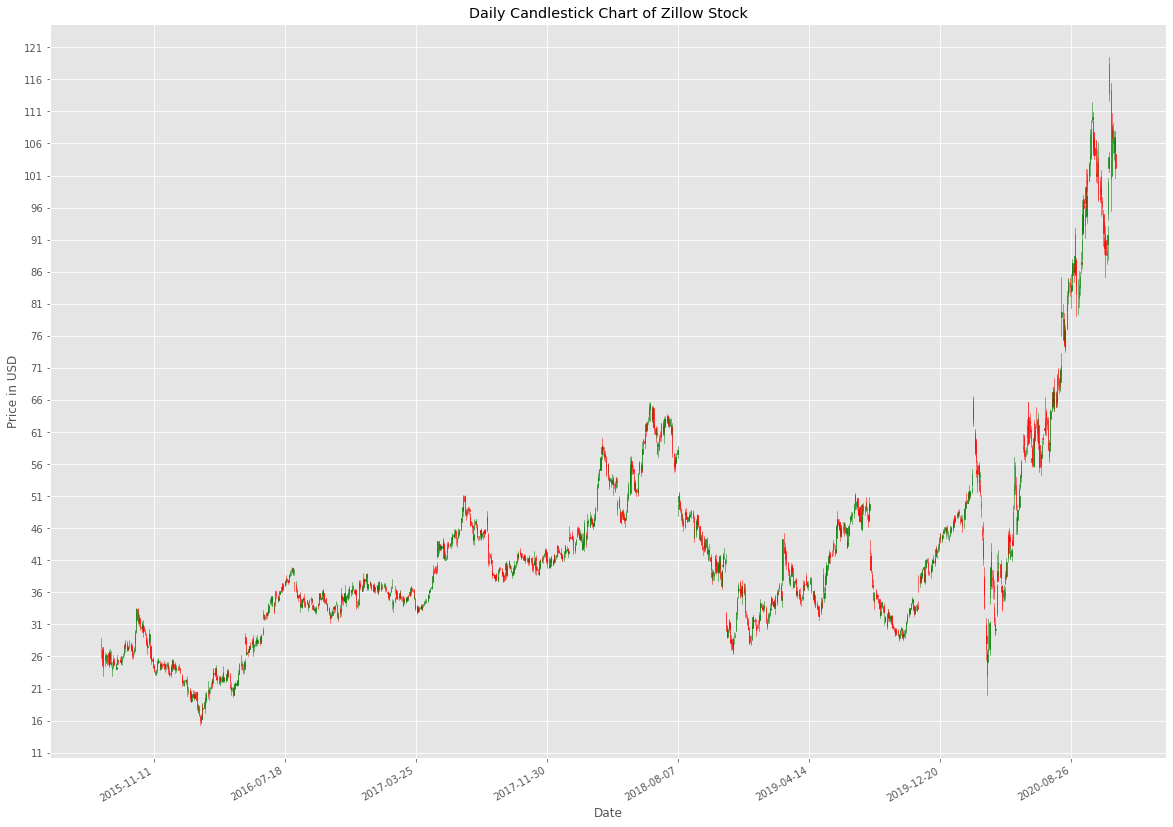

In [62]:
plt.style.use('ggplot')
# Extracting Data for plotting
candle_df = fetched_df.loc[:, ['z_trading_date', 'stock_open_price', 'stock_high_price', 'stock_low_price', 'stock_close_price']]
candle_df['z_trading_date'] = pd.to_datetime(candle_df['z_trading_date'])
candle_df['z_trading_date'] = candle_df['z_trading_date'].apply(mpl_dates.date2num)
candle_df = candle_df.astype(float)

# Creating Subplots
fig, ax = plt.subplots(figsize=(20,15))

max_price = fetched_df['stock_close_price'].max() 
min_price = fetched_df['stock_close_price'].min() 

candlestick_ohlc(ax, candle_df.values, width=0.6, colorup='green', colordown='red', alpha=1.0)

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price in USD')
ax.set_title('Daily Candlestick Chart of Zillow Stock')
# Formatting Date
date_format = mpl_dates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)
ax.set_yticks(range(int(min_price) - 5, int(max_price) + 5, 5))
fig.autofmt_xdate()
plt.show()

#### Lets visualize this candlestick graph with new version of `mpl_finance` library named `mplfinance`

First the data need to be in timeseries format and with columns named Open, High, Low and Close. 

In [63]:
candle_df = fetched_df.loc[:, ['z_trading_date', 'stock_open_price', 'stock_high_price', 'stock_low_price', 'stock_close_price']]
candle_df['z_trading_date'] = pd.DatetimeIndex(candle_df['z_trading_date'])
candle_df = candle_df.set_index(candle_df['z_trading_date'])
candle_df.columns = ['Date', 'Open', 'High','Low','Close']
candle_df.head()

,Date,Open,High,Low,Close
z_trading_date,,,,,
2015-08-03,2015-08-03,27.65,28.82,25.72,27.74
2015-08-04,2015-08-04,27.00,27.03,24.61,25.80
2015-08-05,2015-08-05,27.11,27.47,24.56,25.24
2015-08-06,2015-08-06,24.81,26.95,22.99,26.95
2015-08-07,2015-08-07,27.50,27.50,24.20,26.50


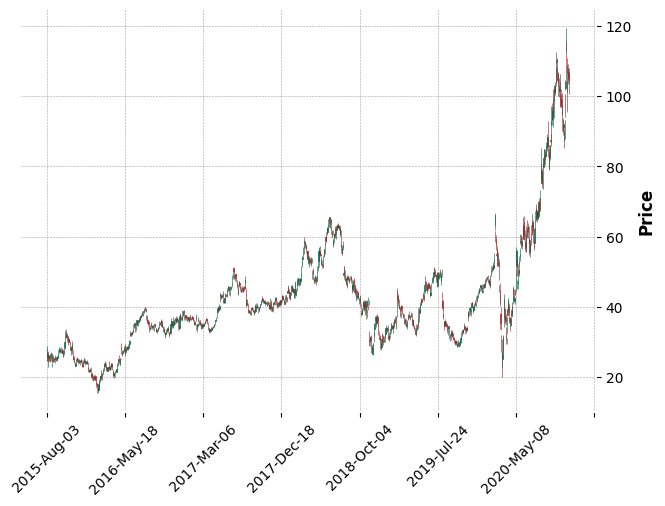

In [64]:
mpf.plot(candle_df,type='candle',  style='charles',)

Great!! New mplfinance is very easy to plot the data. However the data seems to be a lot to fit properly on the figure and show candle stciks properly. Lets use only 1 month data and visualize.

In [65]:
selected_data_df = updated_df[updated_df["z_trading_date"] > "2020-10-01"]
selected_data_df = selected_data_df.sort_values(by=['z_trading_date'])
selected_data_df.head()

,z_trading_date,stock_open_price,stock_high_price,stock_low_price,stock_close_price,stock_adjusted_close_price,stock_day_volume,stock_sma10,stock_sma20,stock_sma50,...,stock_bband_middle_50,stock_bband_lower_100,stock_bband_upper_100,stock_bband_middle_100,stock_bband_lower_200,stock_bband_upper_200,stock_bband_middle_200,stock_ema_50,stock_ema_100,stock_ema_200
1302,2020-10-02,103.92,109.67,103.61,108.18,108.18,2255300.0,101.02,94.54,84.33,...,83.7268,41.4261,101.3801,71.4031,21.7872,93.9697,57.8785,85.2755,74.4822,63.0507
1303,2020-10-05,109.81,112.49,109.38,110.11,110.11,2416800.0,102.46,95.85,85.22,...,84.6320,41.5204,102.5520,72.0362,21.4439,94.9781,58.2110,86.2376,75.1817,63.5160
1304,2020-10-06,109.53,110.94,104.25,104.99,104.99,3297700.0,103.04,97.07,85.98,...,85.4850,41.7371,103.6187,72.6779,21.1134,95.9573,58.5354,87.1511,75.8619,63.9738
1305,2020-10-07,107.71,108.26,104.42,105.51,105.51,3546400.0,103.96,98.23,86.79,...,86.3176,41.9933,104.5723,73.2828,20.8395,96.8582,58.8489,87.9573,76.4925,64.4090
1306,2020-10-08,106.62,106.78,104.05,105.04,105.04,2325500.0,104.68,99.34,87.56,...,87.1336,42.1957,105.4911,73.8434,20.6186,97.7049,59.1618,88.6892,77.0891,64.8290


In [66]:
selected_data_df.shape

(35, 38)

In [67]:
selected_data_df = selected_data_df.rename(columns={'z_trading_date':"Date", 'stock_open_price':"Open", 'stock_high_price':"High", 'stock_low_price':"Low", 'stock_close_price':"Close", 'stock_day_volume':"Volume"})
selected_data_df['Date'] = pd.DatetimeIndex(selected_data_df['Date'])
selected_data_df = selected_data_df.set_index(selected_data_df['Date'])
selected_data_df.tail()

,Date,Open,High,Low,Close,stock_adjusted_close_price,Volume,stock_sma10,stock_sma20,stock_sma50,...,stock_bband_middle_50,stock_bband_lower_100,stock_bband_upper_100,stock_bband_middle_100,stock_bband_lower_200,stock_bband_upper_200,stock_bband_middle_200,stock_ema_50,stock_ema_100,stock_ema_200
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-13,2020-11-13,108.28,109.12,104.50,106.03,106.03,1604900.0,102.91,98.62,97.94,...,98.0117,51.7641,117.1798,84.4720,20.3077,111.9242,66.1160,96.2705,86.4380,72.8916
2020-11-16,2020-11-16,104.71,107.97,103.40,107.04,107.04,3118300.0,104.69,99.05,98.41,...,98.4025,52.3727,117.4816,84.9272,20.3611,112.4524,66.4067,96.6015,86.7998,73.2082
2020-11-17,2020-11-17,106.76,107.88,103.90,105.26,105.26,2247400.0,106.05,99.39,98.90,...,98.9291,52.9843,117.8250,85.4047,20.3877,113.0196,66.7037,96.9998,87.1951,73.5421
2020-11-18,2020-11-18,104.32,106.22,100.54,102.24,102.24,2345600.0,106.28,99.57,99.30,...,99.3677,53.8077,117.9729,85.8903,20.4248,113.5313,66.9781,97.2869,87.5342,73.8483
2020-11-19,2020-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,99.7669,54.6256,118.0655,86.3456,20.4911,113.9982,67.2446,97.4925,87.8311,74.1337


In [68]:
selected_data_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'stock_adjusted_close_price',
       'Volume', 'stock_sma10', 'stock_sma20', 'stock_sma50', 'stock_sma100',
       'stock_sma200', 'stock_s1', 'stock_s2', 'stock_s3', 'stock_pp',
       'stock_r1', 'stock_r2', 'stock_r3', 'stock_macd', 'stock_rsi',
       'stock_12ema', 'stock_26ema', 'stock_dema_50', 'stock_dema_100',
       'stock_dema_200', 'stock_bband_lower_50', 'stock_bband_upper_50',
       'stock_bband_middle_50', 'stock_bband_lower_100',
       'stock_bband_upper_100', 'stock_bband_middle_100',
       'stock_bband_lower_200', 'stock_bband_upper_200',
       'stock_bband_middle_200', 'stock_ema_50', 'stock_ema_100',
       'stock_ema_200'],
      dtype='object')

***Change the datatype of columns to numeric for visualization.***

In [69]:
selected_data_df[['Open', 'High', 'Low', 'Close', 'stock_adjusted_close_price',
       'Volume', 'stock_sma10', 'stock_sma20', 'stock_sma50', 'stock_sma100',
       'stock_sma200', 'stock_s1', 'stock_s2', 'stock_s3', 'stock_pp',
       'stock_r1', 'stock_r2', 'stock_r3', 'stock_macd', 'stock_rsi',
       'stock_12ema', 'stock_26ema', 'stock_dema_50', 'stock_dema_100',
       'stock_dema_200', 'stock_bband_lower_50', 'stock_bband_upper_50',
       'stock_bband_middle_50', 'stock_bband_lower_100',
       'stock_bband_upper_100', 'stock_bband_middle_100',
       'stock_bband_lower_200', 'stock_bband_upper_200',
       'stock_bband_middle_200', 'stock_ema_50', 'stock_ema_100',
       'stock_ema_200']] = selected_data_df[['Open', 'High', 'Low', 'Close', 'stock_adjusted_close_price',
       'Volume', 'stock_sma10', 'stock_sma20', 'stock_sma50', 'stock_sma100',
       'stock_sma200', 'stock_s1', 'stock_s2', 'stock_s3', 'stock_pp',
       'stock_r1', 'stock_r2', 'stock_r3', 'stock_macd', 'stock_rsi',
       'stock_12ema', 'stock_26ema', 'stock_dema_50', 'stock_dema_100',
       'stock_dema_200', 'stock_bband_lower_50', 'stock_bband_upper_50',
       'stock_bband_middle_50', 'stock_bband_lower_100',
       'stock_bband_upper_100', 'stock_bband_middle_100',
       'stock_bband_lower_200', 'stock_bband_upper_200',
       'stock_bband_middle_200', 'stock_ema_50', 'stock_ema_100',
       'stock_ema_200']].apply(pd.to_numeric) 

In [70]:
selected_data_df.dtypes

Date                          datetime64[ns]
Open                                 float64
High                                 float64
Low                                  float64
Close                                float64
stock_adjusted_close_price           float64
Volume                               float64
stock_sma10                          float64
stock_sma20                          float64
stock_sma50                          float64
stock_sma100                         float64
stock_sma200                         float64
stock_s1                             float64
stock_s2                             float64
stock_s3                             float64
stock_pp                             float64
stock_r1                             float64
stock_r2                             float64
stock_r3                             float64
stock_macd                           float64
stock_rsi                            float64
stock_12ema                          float64
stock_26em

#### Bollinger band with stock movement. 

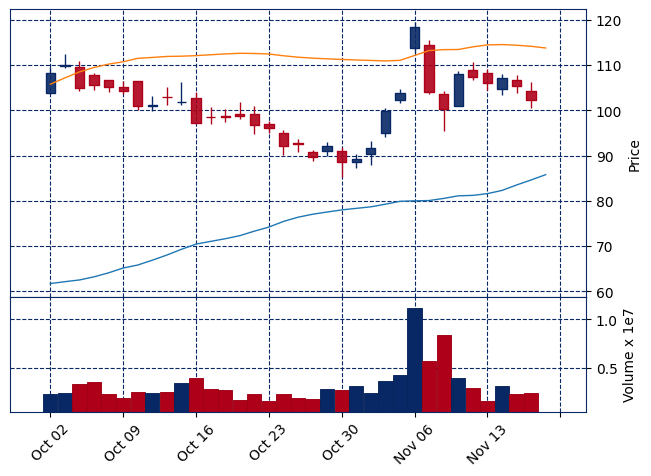

In [71]:
tcdf = selected_data_df[['stock_bband_lower_50','stock_bband_upper_50']]  # DataFrame with two columns
apd  = mpf.make_addplot(tcdf, width=1)
mpf.plot(selected_data_df,addplot=apd, type='candle',  volume=True, style='starsandstripes')

Bollinger band is anohter technical tool which talks about price volatility. In case of above figure the higher band is indicated by orange line and lower band by blue line. If you observe price movement on Nov 6th when it crossed Bollinger band the next day it came down. The reason is because when price crosses above the upper band that means stock is overbought and bound to come down. Where as when price crosses lower band it means stock is in oversold and bound to bounce back. 

#### Plot stock price movement with support and resistence levels of stock. 

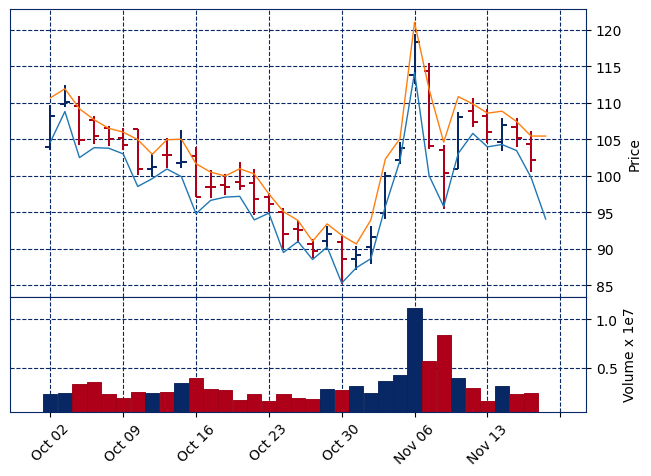

In [72]:
tcdf = selected_data_df[['stock_s1','stock_r1']]  # DataFrame with two columns
apd  = mpf.make_addplot(tcdf, width =1)
mpf.plot(selected_data_df,addplot=apd, volume=True, style='starsandstripes')

This graph helps technical analyst to determine what is the price band for this specific stock. In our graph blue line is the support below which stock may not trade and orage shows resistence level. 

#### Plotting MACD indicator with stock price movement. 

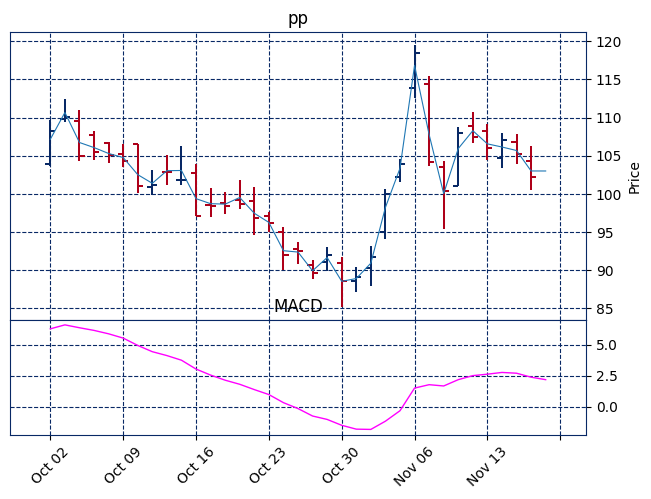

In [73]:
macd_plot = mpf.make_addplot(selected_data_df["stock_macd"],  panel=1, width=1.0, color='fuchsia', title="MACD")
rsi_plot = mpf.make_addplot(selected_data_df["stock_pp"],  panel=0, width=0.8, title="pp")
add_plots = [macd_plot, rsi_plot]
mpf.plot(selected_data_df,addplot=add_plots,  style='starsandstripes')

Above graph shows that when MACD comes down the 0 line it is a sell indicator where as when MACD crosses above zero line it is buy indicator. 

#### Change 'z_trading_date' to period type so that it can be used for plotting data correctly. 

In [74]:
fetched_df['z_trading_date'] = fetched_df.z_trading_date.astype('O')
fetched_df.head()

,z_trading_date,stock_open_price,stock_high_price,stock_low_price,stock_close_price,stock_adjusted_close_price,stock_day_volume,stock_sma10,stock_sma20,stock_sma50,...,stock_s2,stock_s3,stock_pp,stock_r1,stock_r2,stock_r3,stock_macd,stock_rsi,stock_12ema,stock_26ema
0,2015-08-03,27.65,28.82,25.72,27.74,27.74,144700.0,NaN,NaN,NaN,...,-27.1133333333333,None,27.426667,29.1333333333333,30.5266666666667,None,0.0,None,27.740000,27.740000
1,2015-08-04,27.00,27.03,24.61,25.80,25.80,129100.0,NaN,NaN,NaN,...,-25.8266666666667,None,25.813333,27.0166666666667,28.2333333333333,None,-0.154757834757834,None,27.441538,27.596296
2,2015-08-05,27.11,27.47,24.56,25.24,25.24,107700.0,NaN,NaN,NaN,...,-26.2733333333333,None,25.756667,26.9533333333333,28.6666666666667,None,-0.318915593217586,None,27.102840,27.421756
3,2015-08-06,24.81,26.95,22.99,26.95,26.95,73100.0,NaN,NaN,NaN,...,-24.31,None,25.630000,28.27,29.59,None,-0.307484599495542,None,27.079326,27.386811
4,2015-08-07,27.50,27.50,24.20,26.50,26.50,52200.0,NaN,NaN,NaN,...,-25.6333333333333,None,26.066667,27.9333333333333,29.3666666666667,None,-0.330922030630738,None,26.990199,27.321121


#### Using entire data collected to plot simple moving average against closing price of the stock. 

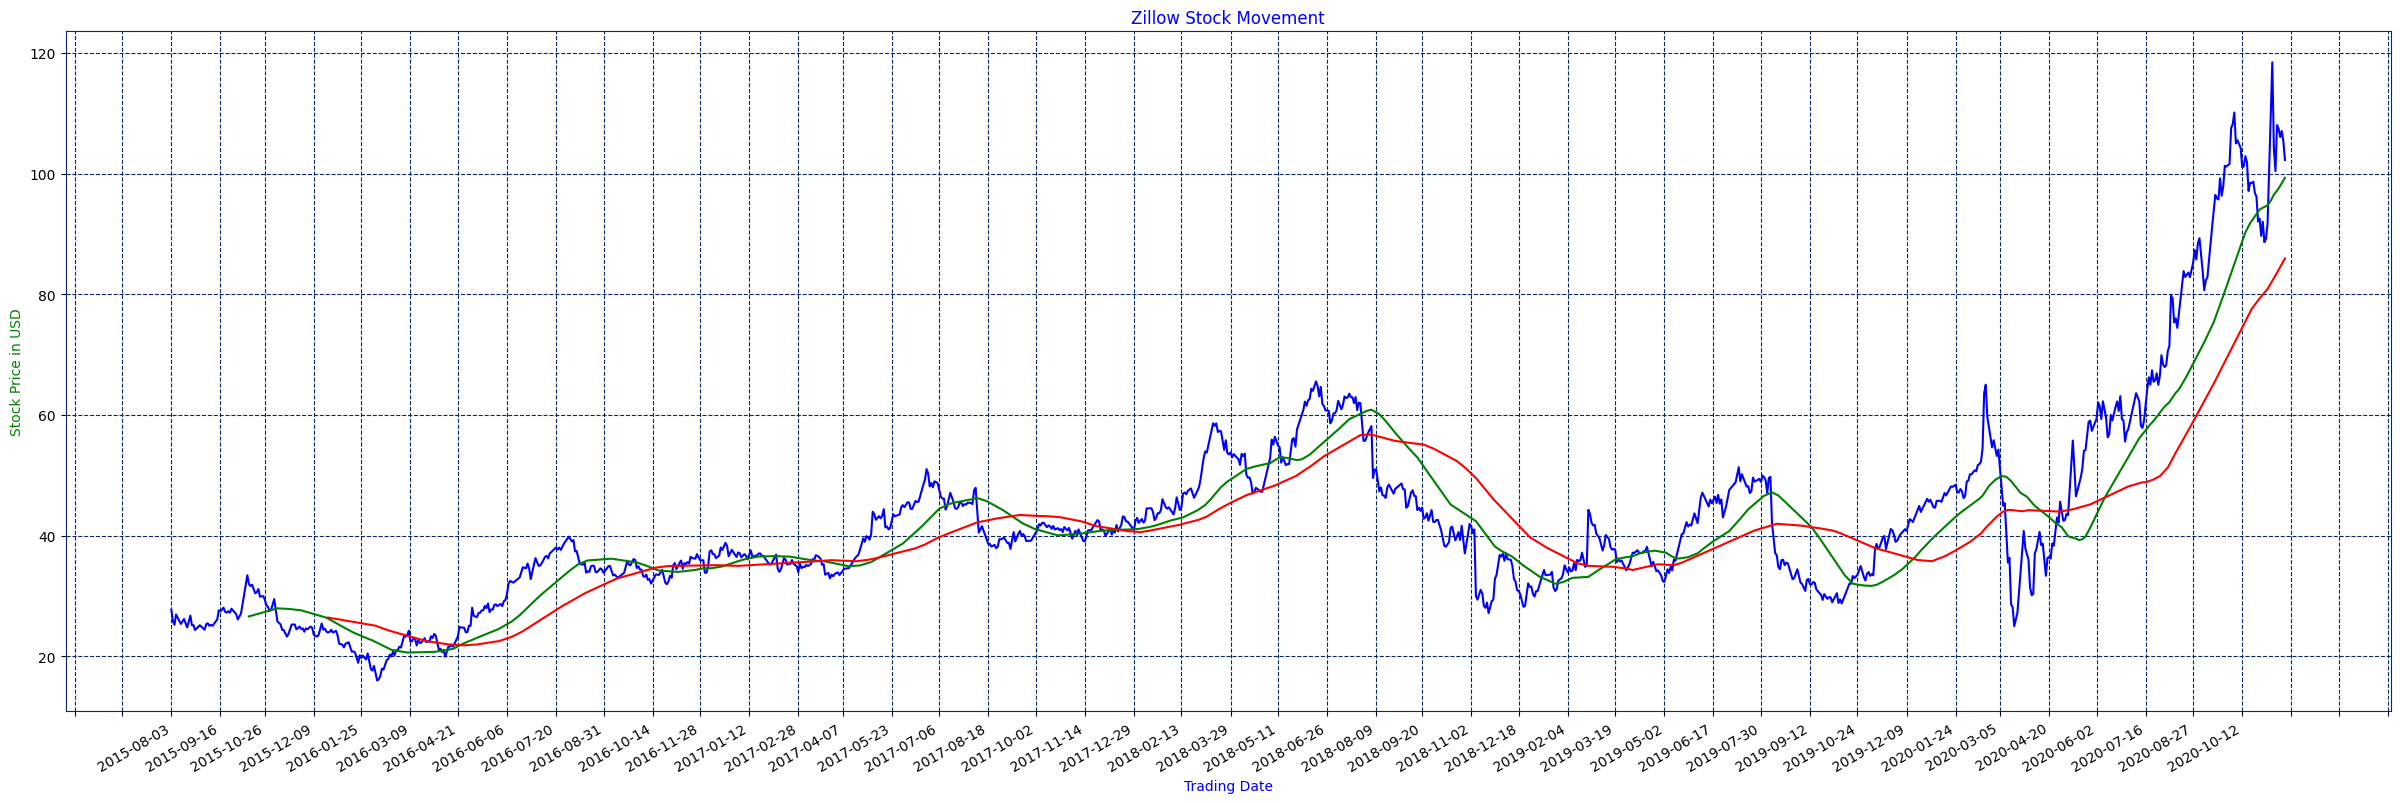

In [75]:
#Stock data with simple moving averages.

fig, ax = plt.subplots(figsize=(30,10))
ax.plot_date(fetched_df['z_trading_date'],fetched_df['stock_close_price'], color='blue', marker='', linestyle='-')
ax.plot_date(fetched_df['z_trading_date'],fetched_df['stock_sma50'], color='green', marker='', linestyle='-')
ax.plot_date(fetched_df['z_trading_date'],fetched_df['stock_sma100'], color='red', marker='', linestyle='-')

ax.tick_params(axis='x', rotation=90)

ax.set_xlabel("Trading Date")
ax.xaxis.label.set_color('blue')

ax.set_ylabel("Stock Price in USD")
ax.yaxis.label.set_color('green')

ax.set_title("Zillow Stock Movement")
ax.title.set_color('blue')

ax.tick_params(axis='x', rotation=90)
plt.gca().xaxis.set_major_locator(mpl_dates.DayLocator((1)))
fig.autofmt_xdate()
ax.fmt_xdata = mpl_dates.DateFormatter('%Y-%m-%d')
plt.show()

Above graphs shows the red line with 100 day moving average and green line with 50 day moving averages. This graph is used by traders to see when the 50 day average crosses 100 day moving average which generates buy/sell signal based on which direction it crosses. 

#### Lets plot only selected data with 50 day and 100 day simple moving averages. 

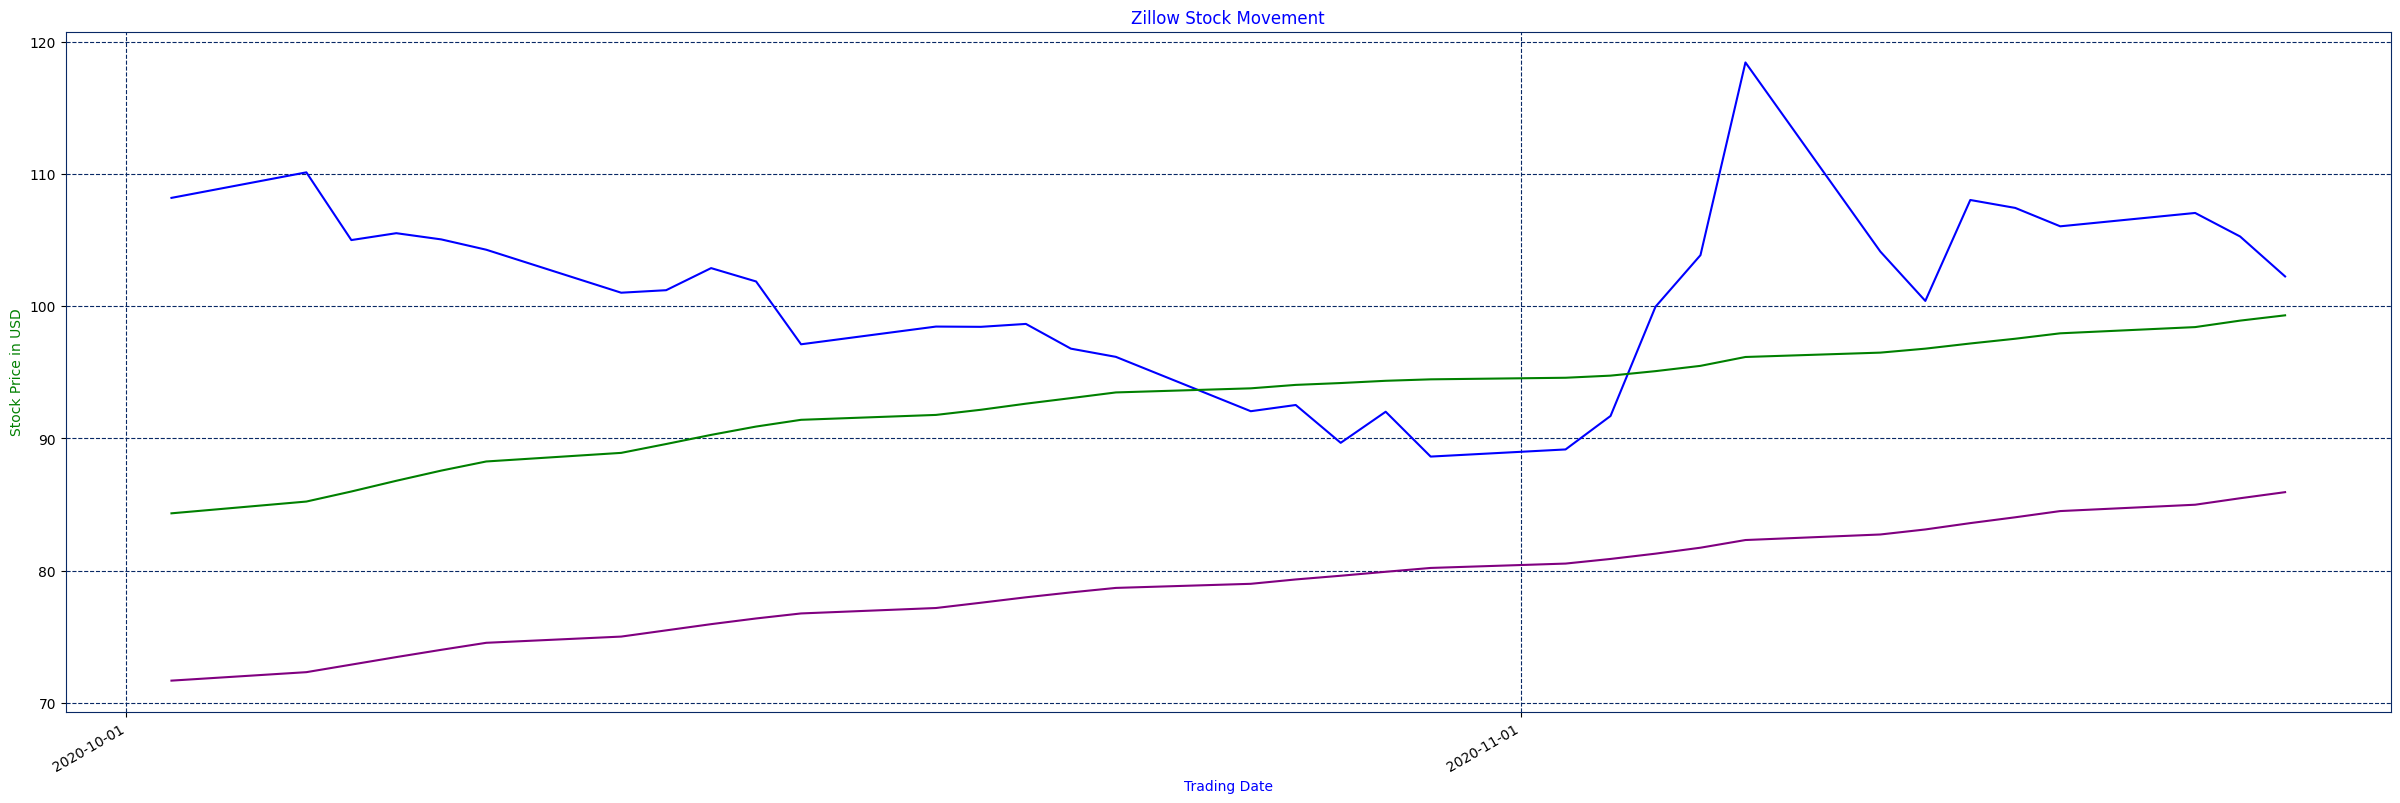

In [76]:
#Stock data with simple moving averages.

fig, ax = plt.subplots(figsize=(30,10))
ax.plot_date(selected_data_df['Date'],selected_data_df['Close'], color='blue', marker='', linestyle='-')
ax.plot_date(selected_data_df['Date'],selected_data_df['stock_sma50'], color='green', marker='', linestyle='-')
ax.plot_date(selected_data_df['Date'],selected_data_df['stock_sma100'], color='purple', marker='', linestyle='-')

ax.tick_params(axis='x', rotation=90)

ax.set_xlabel("Trading Date")
ax.xaxis.label.set_color('blue')

ax.set_ylabel("Stock Price in USD")
ax.yaxis.label.set_color('green')

ax.set_title("Zillow Stock Movement")
ax.title.set_color('blue')

ax.tick_params(axis='x', rotation=90)
plt.gca().xaxis.set_major_locator(mpl_dates.DayLocator((1)))
fig.autofmt_xdate()
ax.fmt_xdata = mpl_dates.DateFormatter('%Y-%m-%d')
plt.show()